In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date, datetime, timedelta

## Visualize COVID-19 historical data

In [37]:
# Read confirmed cases
df_cases_raw = pd.read_csv(os.path.join('data','cases.csv'))        # read csv
df_cases_raw = df_cases_raw.query(" location == 'Bogotá D.C.-Bogotá d C.' ")    # get only for Bogotá
df_cases_raw['date_time'] = pd.to_datetime(df_cases_raw['date_time'], format='%Y-%m-%d')    # converted to datetime

# Perform rolling average over data
rolling_window_size = 7     # days
date_times = df_cases_raw['date_time'].tolist()

# Get data of interest
confirmed_cases = df_cases_raw['num_cases'].rolling(window=rolling_window_size).mean().tolist()
confirmed_deaths = df_cases_raw['num_diseased'].rolling(window=rolling_window_size).mean().tolist()
confirmed_hospital = df_cases_raw['num_infected_in_hospital'].rolling(window=rolling_window_size).mean().tolist()
confirmed_house = df_cases_raw['num_infected_in_house'].rolling(window=rolling_window_size).mean().tolist()

dict_cases = dict(zip(['date_time','confirmed_cases','confirmed_deaths','confirmed_hospital','confirmed_house'],
                      [date_times,confirmed_cases,confirmed_deaths,confirmed_hospital,confirmed_house]))

df_cases = pd.DataFrame(data=dict_cases)

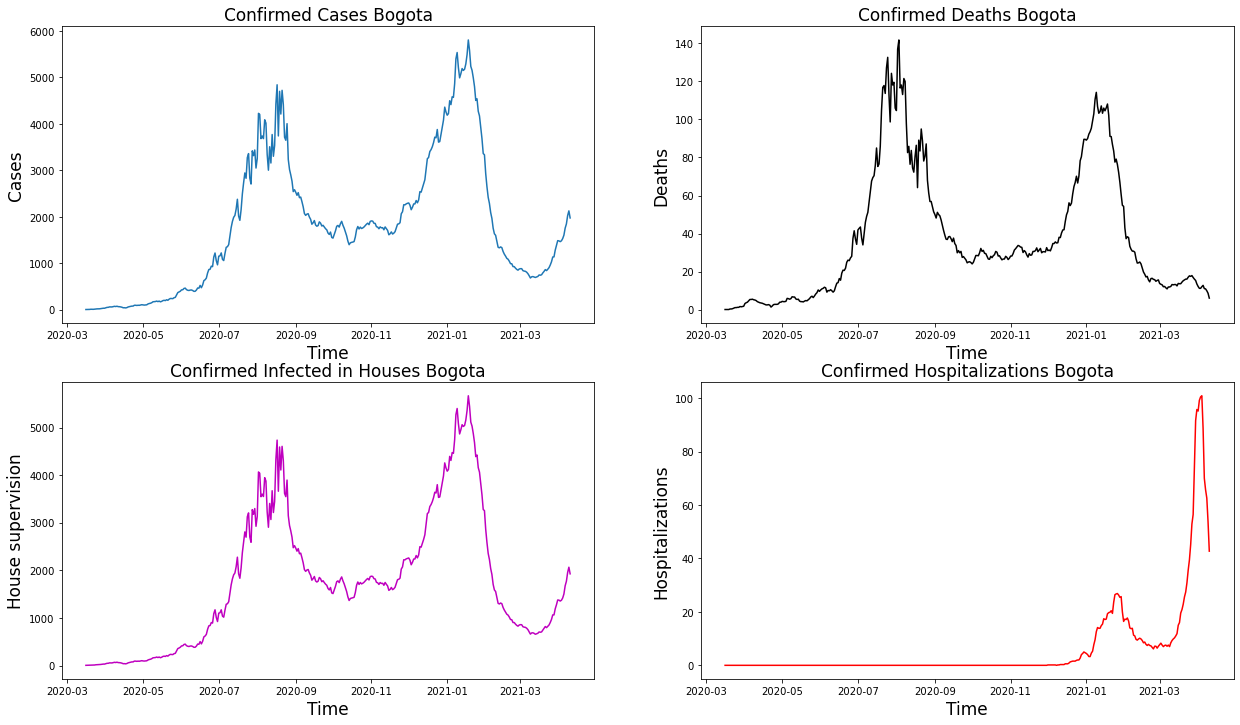

In [38]:
fig,ax = plt.subplots(2,2,figsize=(7*3, 6*2))

sns.lineplot(ax=ax[0,0], data=df_cases,x='date_time',y='confirmed_cases')
ax[0,0].set_xlabel('Time',fontsize=17)
ax[0,0].set_ylabel('Cases',fontsize=17)
ax[0,0].set_title('Confirmed Cases Bogota',fontsize=17)

sns.lineplot(ax=ax[0,1], data=df_cases,x='date_time',y='confirmed_deaths',color='k')
ax[0,1].set_xlabel('Time',fontsize=17)
ax[0,1].set_ylabel('Deaths',fontsize=17)
ax[0,1].set_title('Confirmed Deaths Bogota',fontsize=17)

sns.lineplot(ax=ax[1,0], data=df_cases,x='date_time',y='confirmed_house',color='m')
ax[1,0].set_xlabel('Time',fontsize=17)
ax[1,0].set_ylabel('House supervision',fontsize=17)
ax[1,0].set_title('Confirmed Infected in Houses Bogota',fontsize=17)

sns.lineplot(ax=ax[1,1], data=df_cases,x='date_time',y='confirmed_hospital',color='r')
ax[1,1].set_xlabel('Time',fontsize=17)
ax[1,1].set_ylabel('Hospitalizations',fontsize=17)
ax[1,1].set_title('Confirmed Hospitalizations Bogota',fontsize=17)

plt.show()

## Visualize mobility patterns

In [93]:
# Read mobility data
df_movement_range_raw = pd.read_csv(os.path.join('data','movement_range.csv'))
df_movement_range_raw = df_movement_range_raw.query(" poly_id == '11001' ")    # get only for Bogotá
df_movement_range_raw['date_time'] = pd.to_datetime(df_movement_range_raw['date_time'], format='%Y-%m-%d')    # converted to datetime

df_movement_raw = pd.read_csv(os.path.join('data','movement.csv'))
df_movement_raw = df_movement_raw.query(" end_poly_id == '11001' ")    # get only for people incomming to Bogotá
df_movement_raw['date_time'] = pd.to_datetime(df_movement_raw['date_time'], format='%Y-%m-%d')    # converted to datetime

# Perform rolling average over data
rolling_window_size = 7     # days
date_times_movement_range = df_movement_range_raw['date_time'].tolist()
date_times_movement       = df_movement_raw['date_time'].tolist()

# Get data of interest
movement_range = df_movement_range_raw['movement_change'].rolling(window=rolling_window_size).mean().tolist()
movement       = df_movement_raw['movement'].rolling(window=rolling_window_size).mean().tolist()

dict_movement_range = {'date_time':date_times_movement_range,'movement_change':movement_range}
df_movement_range = pd.DataFrame(data=dict_movement_range)
dict_movement = {'date_time':date_times_movement,'movement':movement}
df_movement = pd.DataFrame(data=dict_movement)

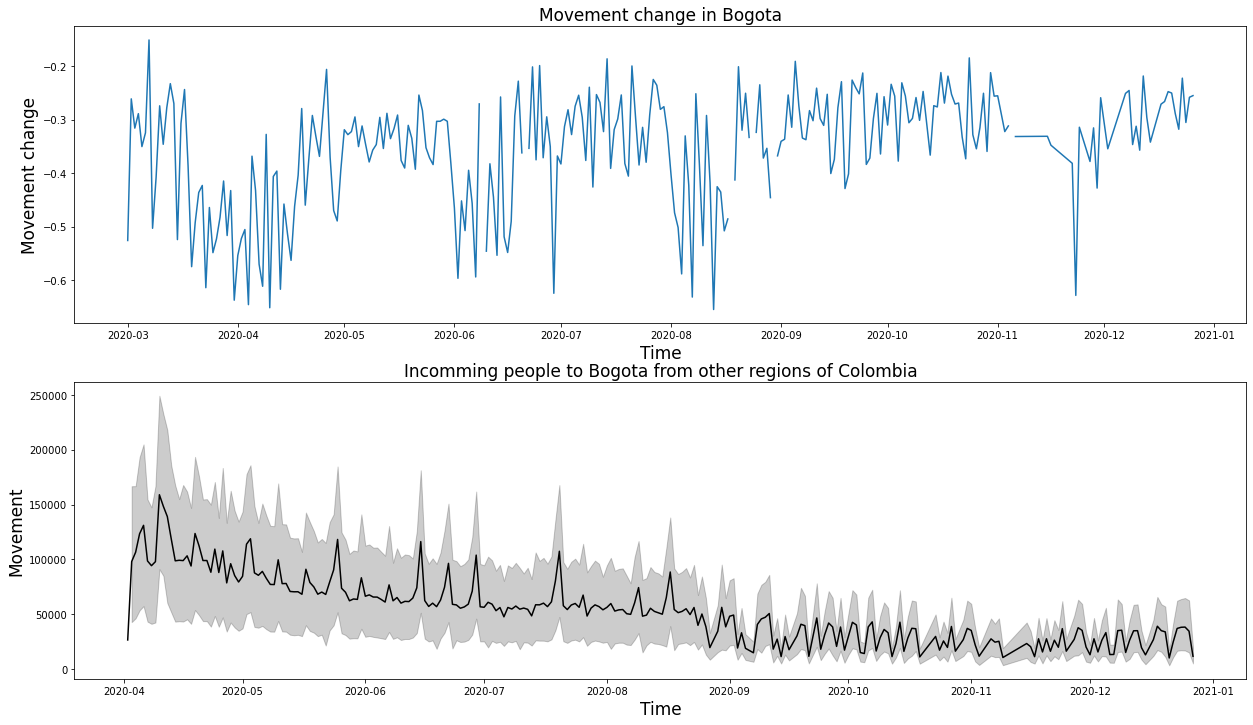

In [98]:
fig,ax = plt.subplots(2,1,figsize=(7*3, 6*2))

sns.lineplot(ax=ax[0], data=df_movement_range,x='date_time',y='movement_change')
ax[0].set_xlabel('Time',fontsize=17)
ax[0].set_ylabel('Movement change',fontsize=17)
ax[0].set_title('Movement change in Bogota',fontsize=17)

sns.lineplot(ax=ax[1], data=df_movement,x='date_time',y='movement',color='k')
ax[1].set_xlabel('Time',fontsize=17)
ax[1].set_ylabel('Movement',fontsize=17)
ax[1].set_title('Incomming people to Bogota from other regions of Colombia',fontsize=17)

plt.show()

## Visualize Google trends data
### Data corresponding to official symptoms of COVID-19, terms COVID-19-related terms with potential to track confirmed cases, and terms used to successfully track ILI activity.

In [33]:
# Import API for Google Trends
from pytrends.request import TrendReq
from pytrends import dailydata
from utils import gtrend

# Read search terms
df_search_terms = pd.read_csv(os.path.join('data','Google_Trends','search_terms_ES.csv'))
search_terms_list = df_search_terms['term'].tolist()

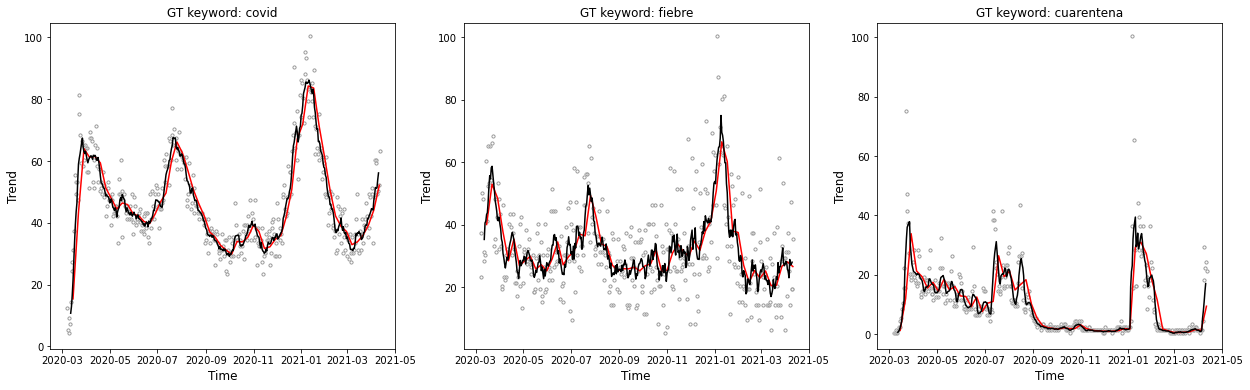

In [72]:
pytrend = TrendReq(hl='es-CO')
keywords_test = ['covid','fiebre','cuarentena']
start = '2020-03-06'
end = '2021-04-10'
geo = 'CO-DC'
cat=0
gprop=''

# Plot raw data
fig,ax = plt.subplots(1,3,figsize=(7*3, 6))
for i, kw in enumerate(keywords_test):
    # Read and process
    overlapping = gtrend.get_daily_trend(pytrend, kw, start, end, geo=geo, cat=cat, gprop=gprop, verbose=False)
    overlapping = overlapping.reset_index()
    overlapping["date"] = pd.to_datetime( overlapping["date"] )
    overlapping['rw'] = overlapping[kw].rolling(window=rolling_window_size).mean()
    overlapping["end_day"] = overlapping.apply(lambda x: x["date"] - timedelta(days=x['date'].weekday()) + timedelta(days=6), axis=1)
    overlapping_week = overlapping.groupby(['end_day']).mean().reset_index()
    # Plot
    sns.scatterplot(ax=ax[i], data=overlapping, x='date', y=kw, marker="$\circ$", color='k')
    sns.lineplot(ax=ax[i], data=overlapping_week, x='end_day', y='rw', color='r')
    sns.lineplot(ax=ax[i], data=overlapping, x='date', y='rw', color='k')
    ax[i].set_xlabel('Time',fontsize=12)
    ax[i].set_ylabel('Trend',fontsize=12)
    ax[i].set_title(f'GT keyword: {kw}',fontsize=12)
plt.show()